In [1]:
import numpy as np
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import DatasetSplitter as ds
import matplotlib.pyplot as plt

training_data, training_labels, testing_data, testing_labels = ds.splitData()

In [2]:
def split_data(training_data):
    mat = np.array(training_data)
    return np.split(mat, indices_or_sections=40)

In [3]:
def get_class_means(split_data):
    return np.mean(split_data, axis=1)

In [4]:
def get_overall_mean(training_data):
    return np.mean(training_data, axis=0)

In [5]:
def get_centered_classes(split_data, class_means):
    centered_classes = []
    for class_matrix, class_mean in zip(split_data, class_means):
        centered_class = []
        for row in class_matrix:
            centered_class.append(row - class_mean)
        centered_classes.append(centered_class)
    return centered_classes

In [6]:
def get_between_class(class_means, overall_mean):
    Sb = np.zeros((10304, 10304))
    for class_mean in class_means:
        Sb += 5 * np.outer(class_mean - overall_mean, class_mean - overall_mean)
    return Sb

In [7]:
def get_within_class(centered_classes):
    Sw = np.zeros((10304, 10304))
    for centered_class in centered_classes:
        mat = np.array(centered_class)
        Sw += np.dot(np.transpose(mat), mat)
    Sw_inverse = sp.linalg.pinv(Sw)
    return Sw_inverse

In [8]:
def get_eigens(Sw_inverse, Sb):
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(Sw_inverse, Sb))
    return eigenvalues, eigenvectors

In [9]:
def get_U(eigenvalues, eigenvectors):
    sorted_indecies = np.argsort(eigenvalues)[::-1]
    sorted_eigen_vectors = eigenvectors[:,sorted_indecies]
    U = np.real(sorted_eigen_vectors[:,:39])
    return U

In [10]:
def LDA(training_data):
    splited_data = split_data(training_data)
    class_means = get_class_means(splited_data)
    overall_mean = get_overall_mean(training_data)
    centered_classes = get_centered_classes(splited_data, class_means)
    Sb = get_between_class(class_means, overall_mean)
    Sw_inverse = get_within_class(centered_classes)
    eigenvalues, eigenvectors = get_eigens(Sw_inverse, Sb)
    U = get_U(eigenvalues, eigenvectors)
    return U

In [12]:
ks = [1, 3, 5, 7]
accuracy_results = np.array([])
projection_matrix = LDA(training_data)
projected_training_data = np.dot(training_data, projection_matrix)
projected_testing_data = np.dot(testing_data, projection_matrix)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(projected_training_data, training_labels)
    predicted_labels = knn.predict(projected_testing_data)
    accuracy = accuracy_score(testing_labels, predicted_labels)
    accuracy_results = np.append(accuracy_results, accuracy * 100)
    print("Accuracy for k = " + str(k) + " is " + str(accuracy * 100))

Accuracy for k = 1 is 95.5
Accuracy for k = 3 is 91.0
Accuracy for k = 5 is 90.5
Accuracy for k = 7 is 89.0


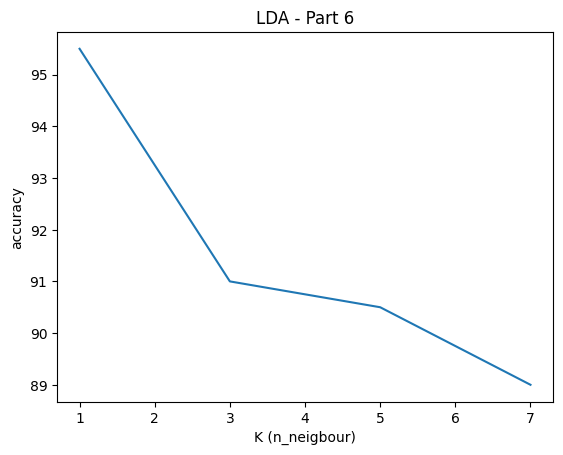

In [13]:
plt.plot(ks, accuracy_results)
plt.xlabel('K (n_neigbour)')
plt.ylabel('accuracy')
plt.title('LDA - Part 6')
plt.show()  